In [1697]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

### Data Preparation and Filtering

In [1698]:
income_grouping_2019 = pd.read_csv('./datasets/World Bank Income Grouping 2019.csv')

# Drop all records with NaN values
income_grouping_2019.dropna(inplace=True)
income_grouping_2019.reset_index(inplace=True, drop=True)

income_grouping_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   region_code      109 non-null    object
 1   region_name      109 non-null    object
 2   country_code     109 non-null    object
 3   country_name     109 non-null    object
 4   income_grouping  109 non-null    object
dtypes: object(5)
memory usage: 4.4+ KB


In [1699]:
ihd_df = pd.read_csv('./datasets/Ischaemic Heart Disease.csv')
ihd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296604 entries, 0 to 296603
Data columns (total 12 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   region_code                                           296604 non-null  object 
 1   region_name                                           296604 non-null  object 
 2   country_code                                          296604 non-null  object 
 3   country_name                                          296604 non-null  object 
 4   year                                                  296604 non-null  int64  
 5   sex                                                   296604 non-null  object 
 6   age_group_code                                        296604 non-null  object 
 7   age_group                                             296604 non-null  object 
 8   num_of_death                                

In [1700]:
ihd_df = pd.read_csv('./datasets/Ischaemic Heart Disease.csv')

# Remove all records with zero (0) number of deaths
#ihd_df_filtered = ihd_df[ihd_df['num_of_death'].notna()]

# NOTE: Records before 1963 were removed due to missing data for Low Middle Income
#ihd_df_filtered = ihd_df_filtered.query("sex == ['Male', 'Female'] and age_group != ['[All]', '[Unknown]'] and (year >= 1963 and year < 2020) and num_of_death != 0")
ihd_df_filtered = ihd_df.query("sex == ['Male', 'Female'] and age_group != ['[All]', '[Unknown]'] and (year >= 1963 and year < 2020)")

# Fill all NaN cells with 0
ihd_df_filtered = ihd_df_filtered.fillna(0)

ihd_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162304 entries, 22 to 296540
Data columns (total 12 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   region_code                                           162304 non-null  object 
 1   region_name                                           162304 non-null  object 
 2   country_code                                          162304 non-null  object 
 3   country_name                                          162304 non-null  object 
 4   year                                                  162304 non-null  int64  
 5   sex                                                   162304 non-null  object 
 6   age_group_code                                        162304 non-null  object 
 7   age_group                                             162304 non-null  object 
 8   num_of_death                               

In [1701]:
# Merge the selected fields from Ischeamic Heart Disease and Income Grouping 2019 tables
ihd_with_ig_df = ihd_df_filtered[['country_code', 'country_name', 'year', 'sex', 'age_group', 'num_of_death', 'death_rate_per_100000']].merge(income_grouping_2019[['country_code', 'income_grouping']], on='country_code')
ihd_with_ig_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158858 entries, 0 to 158857
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country_code           158858 non-null  object 
 1   country_name           158858 non-null  object 
 2   year                   158858 non-null  int64  
 3   sex                    158858 non-null  object 
 4   age_group              158858 non-null  object 
 5   num_of_death           158858 non-null  float64
 6   death_rate_per_100000  158858 non-null  float64
 7   income_grouping        158858 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 10.9+ MB


### Method Declaration

In [1702]:
def groupByIncomeGroupingAndYear(df, income_grouping):
    # Group the records, then aggregate the records by Year
    df_grp_by_income = df.get_group(income_grouping)
    df_grp_by_income_and_year = df_grp_by_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

    #print(f"Income Grouping: {income_grouping}\n")
    #print(df_grp_by_income_and_year)
    
    return df_grp_by_income_and_year


def groupByIncomeGroupingAndSex(df, sex):
    # Group the records, then aggregate the records by Year
    df_grp_by_sex = df.get_group(sex)
    df_grp_by_sex_and_year = df_grp_by_sex[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

    #print(f"Sex: {sex}\n")
    #print(df_grp_by_sex_and_year)
    
    return df_grp_by_sex_and_year

### Data Analysis on Income Grouping

In [1703]:
# Group data by income_grouping
ihd_with_ig_grp_income = ihd_with_ig_df.groupby(['income_grouping']) 

# Display summary statistics of 'death_rate_per_100000' for each income group   
ihd_with_ig_grp_income['death_rate_per_100000'].describe()  

,count,mean,std,min,25%,50%,75%,max
income_grouping,,,,,,,,
High Income,87026.0,438.655236,1141.792796,0.0,0.000000,10.232186,274.498318,26000.00000
Low Middle Income,14832.0,714.772085,1942.057489,0.0,1.126915,20.969511,313.472838,20608.95823
Upper Middle Income,57000.0,369.619500,1053.406114,0.0,0.000000,10.720083,225.784904,19016.29073


In [1704]:
# Group the records by 'High Income' bracket, then aggregate the records by Year
ihd_with_ig_grp_high_income_and_year = groupByIncomeGroupingAndYear(ihd_with_ig_grp_income, 'High Income')

year_by_high_income = ihd_with_ig_grp_high_income_and_year['year']
death_rate_per_100000_by_high_income = ihd_with_ig_grp_high_income_and_year['death_rate_per_100000']

In [1705]:
# Group the records by 'Upper Middle Income' bracket, then aggregate the records by Year
ihd_with_ig_grp_upper_mid_income_and_year = groupByIncomeGroupingAndYear(ihd_with_ig_grp_income, 'Upper Middle Income')

year_by_upper_mid_income = ihd_with_ig_grp_upper_mid_income_and_year['year']
death_rate_per_100000_by_upper_mid_income = ihd_with_ig_grp_upper_mid_income_and_year['death_rate_per_100000']

In [1706]:
# Group the records by 'Low Middle Income' bracket, then aggregate the records by Year
ihd_with_ig_grp_low_mid_income_and_year = groupByIncomeGroupingAndYear(ihd_with_ig_grp_income, 'Low Middle Income')

year_by_low_mid_income = ihd_with_ig_grp_low_mid_income_and_year['year']
death_rate_per_100000_by_low_mid_income = ihd_with_ig_grp_low_mid_income_and_year['death_rate_per_100000']

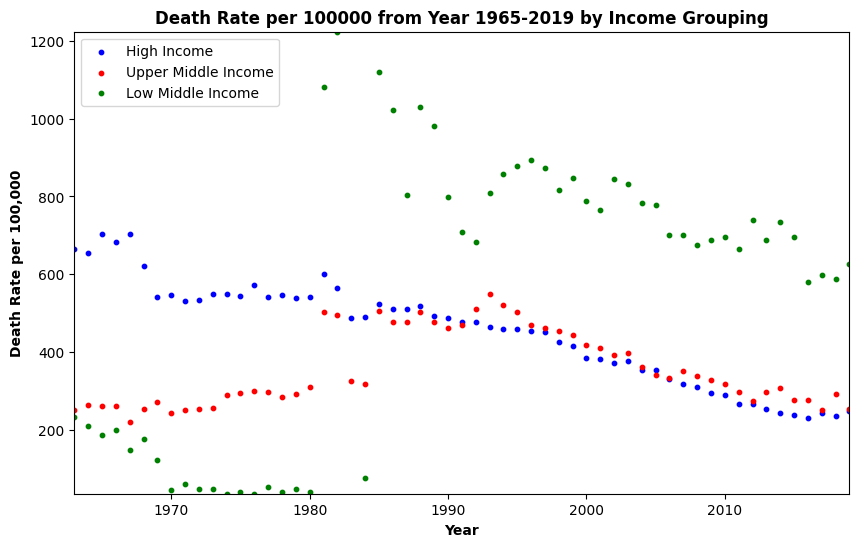

In [1707]:
# Plot the graph of Death Rate per 100000 for each Year based on Income Grouping
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.set_xmargin(0)
ax1.set_ymargin(0)
ax1.set_xlabel("Year", fontdict={'weight':'bold'})
ax1.set_ylabel("Death Rate per 100,000", fontdict={'weight':'bold'})
ax1.set_title("Death Rate per 100000 from Year 1965-2019 by Income Grouping", fontdict={'size':'large', 'weight':'bold'})

ax1.scatter(year_by_high_income, death_rate_per_100000_by_high_income, s=10, c='b', label='High Income')
ax1.scatter(year_by_upper_mid_income, death_rate_per_100000_by_upper_mid_income, s=10, c='r', label='Upper Middle Income')
ax1.scatter(year_by_low_mid_income, death_rate_per_100000_by_low_mid_income, s=10, c='g', label='Low Middle Income')
plt.legend(loc='upper left')
plt.show()

### Data Analysis on Sex

In [1708]:
# Group data by income_grouping
ihd_with_ig_grp_sex = ihd_with_ig_df.groupby(['sex']) 

# Display summary statistics of 'death_rate_per_100000' for each income group   
ihd_with_ig_grp_sex['death_rate_per_100000'].describe()  

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
Female,79429.0,361.632595,1102.862013,0.0,0.000000,5.957006,154.202005,22333.33333
Male,79429.0,517.696386,1310.767882,0.0,0.067681,23.613242,378.643617,26000.00000


In [1709]:
# Group the records by Male, then aggregate the records by Year
ihd_with_ig_grp_male_and_year = groupByIncomeGroupingAndSex(ihd_with_ig_grp_sex, 'Male')

year_by_male = ihd_with_ig_grp_male_and_year['year']
death_rate_per_100000_by_male = ihd_with_ig_grp_male_and_year['death_rate_per_100000']

In [1710]:
# Group the records by Female, then aggregate the records by Year
ihd_with_ig_grp_female_and_year = groupByIncomeGroupingAndSex(ihd_with_ig_grp_sex, 'Female')

year_by_female = ihd_with_ig_grp_female_and_year['year']
death_rate_per_100000_by_female = ihd_with_ig_grp_female_and_year['death_rate_per_100000']

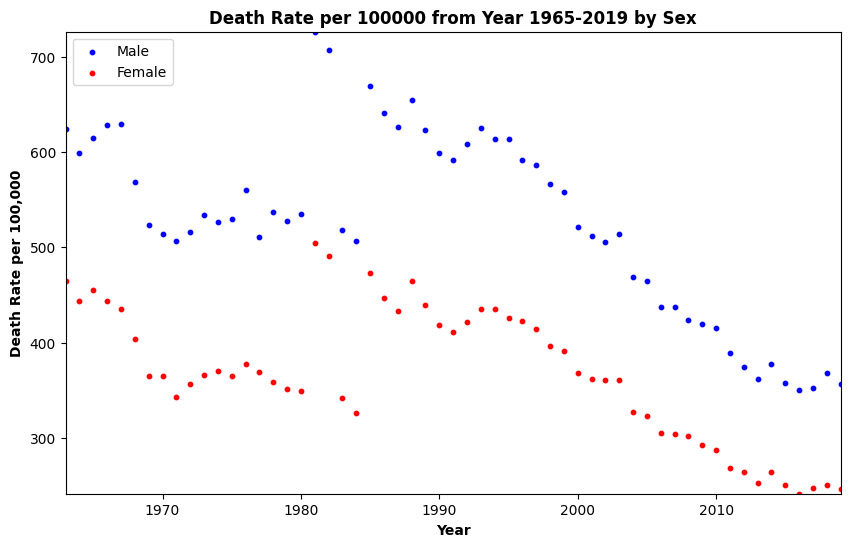

In [1711]:
# Plot the graph of Death Rate per 100000 for each Year based on Sex
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.set_xmargin(0)
ax1.set_ymargin(0)
ax1.set_xlabel("Year", fontdict={'weight':'bold'})
ax1.set_ylabel("Death Rate per 100,000", fontdict={'weight':'bold'})
ax1.set_title("Death Rate per 100000 from Year 1965-2019 by Sex", fontdict={'size':'large', 'weight':'bold'})

ax1.scatter(year_by_male, death_rate_per_100000_by_male, s=10, c='b', label='Male')
ax1.scatter(year_by_female, death_rate_per_100000_by_female, s=10, c='r', label='Female')
plt.legend(loc='upper left')
plt.show()

### Data Analysis on Age Group

In [1712]:
# Regroup the category of the previous age group
# Reference for age grouping: https://www.statcan.gc.ca/en/concepts/definitions/age2

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[0]', 'Children', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[1-4]', 'Children', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[5-9]', 'Children', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[10-14]', 'Children', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[15-19]', 'Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[20-24]', 'Youth', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[25-29]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[30-34]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[35-39]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[40-44]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[45-49]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[50-54]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[55-59]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[60-64]', 'Adults', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[65-69]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[70-74]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[75-79]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[80-84]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[85+]', 'Seniors', ihd_with_ig_df['age_group'])


# Group data by income_grouping
ihd_with_ig_df.groupby(['age_group', 'sex'])['death_rate_per_100000'].describe()

count         mean          std  min         25%  \
age_group sex                                                          
Adults    Female  33476.0    38.203331    71.066509  0.0    1.676688   
          Male    33476.0   117.704032   188.134179  0.0    7.250279   
Children  Female  16777.0     0.308999     4.223460  0.0    0.000000   
          Male    16777.0     0.336490     3.346015  0.0    0.000000   
Seniors   Female  20807.0  1318.588679  1842.095768  0.0  261.150145   
          Male    20807.0  1786.222735  2076.570448  0.0  501.453196   
Youth     Female   8369.0     0.497302     1.174247  0.0    0.000000   
          Male     8369.0     0.987495     1.805079  0.0    0.000000   

                          50%          75%           max  
age_group sex                                             
Adults    Female     9.630357    40.953459    821.978022  
          Male      39.467947   145.166641   1711.553829  
Children  Female     0.000000     0.000000    420.609884  
          Male       0.000000     0.000000    194.552529  
Seniors   Female   650.054171  1562.634166  22333.333330  
          Male    1083.462016  2241.267642  26000.000000  
Youth     Female     0.000000     0.595692     32.258065  
          Male       0.413365     1.297017     60.168472

### Method Declaration

In [1713]:
def evaluateModel(model, x_train, x_test, y_train, y_test, y_pred):
    
    print(f"Score: {model.score(x_test, y_test)}\n")

    # Classification report without cross-validation
    print("Classification Report")
    print(classification_report(y_test, y_pred))

    # k-fold cross-validation and confusion matrices
    y_train_pred = cross_val_predict(model, x_train, y_train, cv=5)
    print("Confusion Matrix")
    print(confusion_matrix(y_train, y_train_pred), "\n")

    print(f"Precision Score: {precision_score(y_train, y_train_pred)}")
    
    
def modelCreation(x, y):

    # Split data into training data sets and test data sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

    print("No. of Train Datasets: ", x_train.shape, y_train.shape)
    print("No. of Test Datasets: ", x_test.shape, y_test.shape)
    print()
    
    model = LogisticRegression(solver='saga')
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    evaluateModel(model, x_train, x_test, y_train, y_test, y_pred)

    return model
    

### Logistic Regression

##### Data Preparation: Converting Categorical Features

In [1714]:
# Check the data types of the fields
ihd_with_ig_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158858 entries, 0 to 158857
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country_code           158858 non-null  object 
 1   country_name           158858 non-null  object 
 2   year                   158858 non-null  int64  
 3   sex                    158858 non-null  object 
 4   age_group              158858 non-null  object 
 5   num_of_death           158858 non-null  float64
 6   death_rate_per_100000  158858 non-null  float64
 7   income_grouping        158858 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 10.9+ MB


In [1715]:
# Convert income grouping to dummy variables
income_grouping_df = pd.get_dummies(ihd_with_ig_df['income_grouping'])
income_grouping_df.columns = ['high_income', 'low_middle_income', 'upper_middle_income']

# Convert sex to dummy variables
male_gender_df = pd.get_dummies(ihd_with_ig_df['sex'], drop_first=True)
male_gender_df.columns = ['male_gender']

# Convert age grouping to dummy variables
age_grouping_df = pd.get_dummies(ihd_with_ig_df['age_group'])
age_grouping_df.columns = ['adults', 'children', 'seniors', 'youth']

# Drop sex, age grouping and income grouping, and other unnecessary columns
ihd_with_ig_df_dummy = ihd_with_ig_df.copy()
ihd_with_ig_df_dummy.drop(['country_code', 'country_name', 'sex', 'income_grouping', 'year', 'age_group', 'num_of_death'], axis=1, inplace=True)

# Add the dummy columns
# ihd_with_ig_df_dummy = pd.concat([ihd_with_ig_df_dummy, male_gender_df, age_grouping_df, income_grouping_df], axis=1, verify_integrity=True)
ihd_with_ig_df_dummy = pd.concat([ihd_with_ig_df_dummy, male_gender_df, income_grouping_df], axis=1, verify_integrity=True)
ihd_with_ig_df_dummy.head(5)

,death_rate_per_100000,male_gender,high_income,low_middle_income,upper_middle_income
0,0.000000,1,0,0,1
1,0.000000,1,0,0,1
2,0.000000,1,0,0,1
3,0.000000,1,0,0,1
4,0.617665,1,0,0,1


##### Model Creation for each Age Grouping

In [1716]:
model_seniors = modelCreation(ihd_with_ig_df_dummy, age_grouping_df['seniors'])

No. of Train Datasets:  (111200, 5) (111200,)
No. of Test Datasets:  (47658, 5) (47658,)

Score: 0.7682026102648034

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.70      0.81     34923
           1       0.54      0.97      0.69     12735

    accuracy                           0.77     47658
   macro avg       0.76      0.83      0.75     47658
weighted avg       0.86      0.77      0.78     47658

Confusion Matrix
[[55427 26894]
 [  952 27927]] 

Precision Score: 0.5094215720253188


In [1717]:
model_adults = modelCreation(ihd_with_ig_df_dummy, age_grouping_df['adults'])

No. of Train Datasets:  (111200, 5) (111200,)
No. of Test Datasets:  (47658, 5) (47658,)

Score: 0.3555751395358597

Classification Report
              precision    recall  f1-score   support

           0       0.45      0.51      0.48     27846
           1       0.17      0.14      0.15     19812

    accuracy                           0.36     47658
   macro avg       0.31      0.32      0.32     47658
weighted avg       0.34      0.36      0.34     47658

Confusion Matrix
[[32813 31247]
 [41016  6124]] 

Precision Score: 0.16387038077653795


In [1718]:
model_youth = modelCreation(ihd_with_ig_df_dummy, age_grouping_df['youth'])

No. of Train Datasets:  (111200, 5) (111200,)
No. of Test Datasets:  (47658, 5) (47658,)

Score: 0.8942674891938395

Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     42619
           1       0.00      0.00      0.00      5039

    accuracy                           0.89     47658
   macro avg       0.45      0.50      0.47     47658
weighted avg       0.80      0.89      0.84     47658

Confusion Matrix
[[99501     0]
 [11699     0]] 

Precision Score: 0.0


In [1719]:
model_children = modelCreation(ihd_with_ig_df_dummy, age_grouping_df['children'])

No. of Train Datasets:  (111200, 5) (111200,)
No. of Test Datasets:  (47658, 5) (47658,)

Score: 0.7886608754039196

Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     37586
           1       0.00      0.00      0.00     10072

    accuracy                           0.79     47658
   macro avg       0.39      0.50      0.44     47658
weighted avg       0.62      0.79      0.70     47658

Confusion Matrix
[[87718     0]
 [23482     0]] 

Precision Score: 0.0


##### Make test prediction

In [1720]:
def getPrediction(age_group, model, input):
    df = np.array(input).reshape(1,-1)

    print(f"{age_group.upper()}")

    print(f"Prediction: {model.predict(df)[0]}")
    print(f"Probability Estimates: {model.predict_proba(df)[0]}")
    print()

def testPrediction(date_rate, male_gender, high_income, upper_middle_income, low_middle_income):

    print("DATASET")
    print(f"Male Gender: {male_gender}")
    print(f"High Income: {high_income} | Upper Middle Income: {upper_middle_income} | Low Middle Income: {low_middle_income}")
    print(f"Date Rate: {date_rate}")
    print()
    
    getPrediction('Seniors', model_seniors, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

    getPrediction('Adults', model_adults, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

    getPrediction('Youth', model_youth, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

    getPrediction('Children', model_children, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

In [1721]:
date_rate = 700
male_gender = 1
high_income = 0
upper_middle_income = 0
low_middle_income = 1

testPrediction(date_rate, male_gender, high_income, upper_middle_income, low_middle_income)


DATASET
Male Gender: 1
High Income: 0 | Upper Middle Income: 0 | Low Middle Income: 1
Date Rate: 700

SENIORS
Prediction: 1
Probability Estimates: [0.21501115 0.78498885]

ADULTS
Prediction: 0
Probability Estimates: [0.78637405 0.21362595]

YOUTH
Prediction: 0
Probability Estimates: [1.00000000e+00 9.29092938e-22]

CHILDREN
Prediction: 0
Probability Estimates: [1.00000000e+00 7.10810742e-22]



In [1722]:
date_rate = 21
male_gender = 0
high_income = 0
upper_middle_income = 0
low_middle_income = 1

testPrediction(date_rate, male_gender, high_income, upper_middle_income, low_middle_income)

DATASET
Male Gender: 0
High Income: 0 | Upper Middle Income: 0 | Low Middle Income: 1
Date Rate: 21

SENIORS
Prediction: 1
Probability Estimates: [0.49595366 0.50404634]

ADULTS
Prediction: 0
Probability Estimates: [0.50950288 0.49049712]

YOUTH
Prediction: 0
Probability Estimates: [0.81219447 0.18780553]

CHILDREN
Prediction: 0
Probability Estimates: [0.81231352 0.18768648]

